In [1]:
import os,sys,signal, copy
import math

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
import matplotlib.ticker as ticker
from matplotlib.animation import ArtistAnimation

from scipy.fftpack import fft
from scipy.signal.windows import hann

import musicnet

from time import time

sys.path.insert(0,'lib/')
import config
import diagnosticsP3
# import base_model

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='1'

import torch
from torch.nn.functional import conv1d, mse_loss
from torchcontrib.optim import SWA

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [3]:
# lvl1 convolutions are shared between regions
m = 128
k = 500              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 500
regions = 1 + (window - n_fft)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': 20, 'pin_memory': True, 'worker_init_fn': worker_init}

root = '../'
train_set = musicnet.MusicNet(root=root, train=True, download=True, window=window)#, pitch_shift=5, jitter=.1)
test_set = musicnet.MusicNet(root=root, train=False, window=window, epoch_size=50000)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

In [6]:
def create_filtersv2(n_fft, freq_bins=None, low=50,high=6000, mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = torch.arange(0, n_fft, 1.)
    wsin = torch.empty((freq_bins,1,n_fft))
    wcos = torch.empty((freq_bins,1,n_fft))
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = 0.5-0.5*torch.cos(2*math.pi*s/(n_fft)) # same as hann(n_fft, sym=False)
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        

    for k in range(freq_bins): # Only half of the bins contain useful info
        wsin[k,0,:] = window_mask*torch.sin(2*math.pi*k*s/n_fft)
        wcos[k,0,:] = window_mask*torch.cos(2*math.pi*k*s/n_fft)
    
    return wsin,wcos


In [7]:
def create_filters(n_fft, freq_bins=None, low=50,high=6000, mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = np.arange(0, n_fft, 1)
    wsin = np.empty((freq_bins,1,n_fft), dtype=np.float32)
    wcos = np.empty((freq_bins,1,n_fft), dtype=np.float32)
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = hann(n_fft, sym=False) # same as 0.5-0.5*np.cos(2*np.pi*x/(k))
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        

    for k in range(freq_bins): # Only half of the bins contain useful info
        wsin[k,0,:] = window_mask*np.sin(2*np.pi*k*s/n_fft)
        wcos[k,0,:] = window_mask*np.cos(2*np.pi*k*s/n_fft)
    
    return wsin,wcos


In [8]:
def L(y_hat, y):
    # adjust for per-frame loss
    return mse_loss(y_hat, y)

In [9]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Create filter windows
        wsin, wcos = create_filtersv2(n_fft,k, mode="stft")
        with torch.cuda.device(0):
            self.wsin = torch.Tensor(wsin).cuda()
            self.wcos = torch.Tensor(wcos).cuda()
            
        # Creating Layers
        self.linear = torch.nn.Linear(regions*k, m)
        torch.nn.init.constant_(self.linear.weight, 0) # initialize
        
    def forward(self,x):
        zx = conv1d(x[:,None,:], self.wsin, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos, stride=stride).pow(2)
        return self.linear(torch.log(zx + 10e-8).view(x.data.size()[0],regions*k))

In [10]:
from time import time

start = time()
wsin, wcos = create_filters(n_fft,k, mode="stft")
with torch.cuda.device(0):
    wsin = torch.Tensor(wsin).cuda()
    wcos = torch.Tensor(wcos).cuda()
    
print(time()-start)

4.6217241287231445


In [11]:
loss_history = []
avgp_history = []

In [12]:
from time import time

start = time()
wsin, wcos = create_filtersv2(n_fft,k, mode="stft")
with torch.cuda.device(0):
    wsin = torch.Tensor(wsin).cuda()
    wcos = torch.Tensor(wcos).cuda()
    
print(time()-start)

0.08610177040100098


In [14]:
model = Model()
model.cuda()

Model(
  (linear): Linear(in_features=12500, out_features=128, bias=True)
)

squre loss	avg prec	time		utime
1.972951	0.017810	12.655875	6.518234
1.795774	0.018182	12.243808	6.534265
1.681589	0.018627	12.366452	6.526365
1.593291	0.018818	12.386781	6.481982
1.522859	0.019067	12.486458	6.531895
1.460524	0.019193	12.640348	6.606724
1.411385	0.019759	12.815799	6.673159
1.368213	0.019766	12.784665	6.771691
1.330933	0.020178	12.797014	6.689643
1.299782	0.020406	12.922500	6.746353
Finsihed


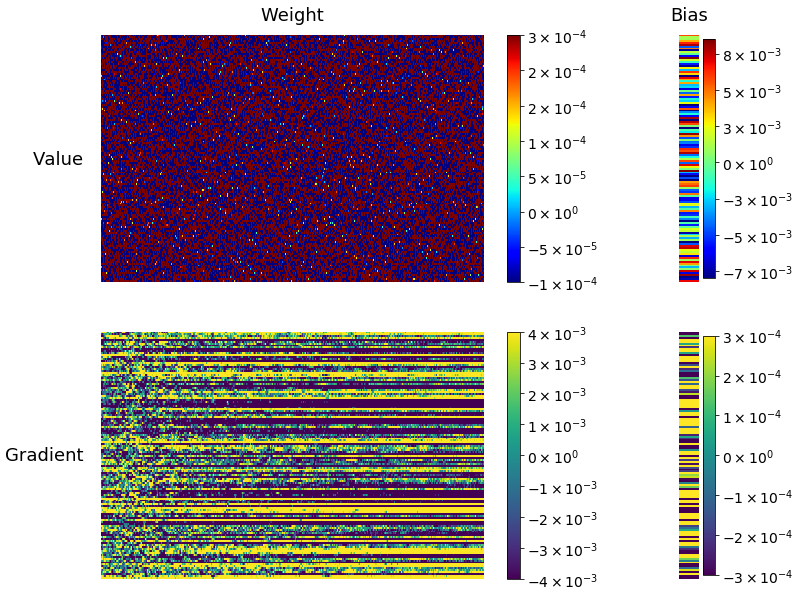

In [15]:
avg = .9998
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001, momentum=.95)
ims = []

numrows=2
numcols=2
fig, ax = plt.subplots(numrows,numcols, gridspec_kw={'width_ratios':[6,1]}, figsize=(11,10))
im1_range = [2.5e-4,-1e-4]
im2_range = [8.5e-3 , -8e-3]
im3_range = [4e-3, -4e-3]
im4_range = [3e-4, -3e-4]

im1 = ax[0,0].imshow(model.linear.weight.data.cpu().numpy(), aspect='auto',
                     vmax=im1_range[0], vmin=im1_range[1], cmap='jet')
im2 = ax[0,1].imshow(model.linear.bias.view(-1,1).data.cpu().numpy(),
                     vmax=im2_range[0], vmin=im2_range[1], aspect=0.1, cmap='jet')
im3 = ax[1,0].imshow(torch.zeros(model.linear.weight.shape),
                     vmax=im3_range[0], vmin=im3_range[1], aspect='auto')
im4 = ax[1,1].imshow(torch.zeros(model.linear.bias.shape).view(-1,1),
                     vmax=im4_range[0], vmin=im4_range[1], aspect=0.1)

ims.append([im1, im2, im3, im4])
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)
try:
    with train_set, test_set:
        total_i = len(train_loader)
        print("squre loss\tavg prec\ttime\t\tutime")
        for epoch in range(10):
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"{i}/{total_i} batches", end = '\r')
                optimizer.zero_grad()
                
                # making x and y into pytorch dealable format
                x = x.cuda(non_blocking=True)
                y = y.cuda(non_blocking=True)
                
                loss = L(model(x),y)
                loss.backward()
                optimizer.step()
                if i%20 == 0: # Plot the weight every 20 iterations
                    im1 = ax[0,0].imshow(model.linear.weight.data.cpu().numpy(), aspect='auto',
                                         vmax=im1_range[0], vmin=im1_range[1], cmap='jet')
                    im2 = ax[0,1].imshow(model.linear.bias.view(-1,1).data.cpu().numpy(),
                                         vmax=im2_range[0], vmin=im2_range[1], aspect=0.1, cmap='jet')
                    im3 = ax[1,0].imshow(model.linear.weight.grad.data.cpu().numpy(),
                                         vmax=im3_range[0], vmin=im3_range[1], aspect='auto')
                    im4 = ax[1,1].imshow(model.linear.bias.grad.view(-1,1).data.cpu().numpy(),
                                         vmax=im4_range[0], vmin=im4_range[1], aspect=0.1)
                    ims.append([im1, im2, im3, im4])                  
                    
            t1 = time()
            avgp, loss = 0.,0.
            
#             optimizer.swap_swa_sgd() # change to average weight
            
            # For testing
            yground = torch.FloatTensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            
            
            for i, (x_test,y_test) in enumerate(test_loader):
                x_test = x_test.cuda()
                y_test = y_test.cuda()
                yhatvar = model(x_test)
                loss += L(yhatvar, y_test).item() #getting the number
                yground[i*batch_size:(i+1)*batch_size,:] = y_test.data
                yhat[i*batch_size:(i+1)*batch_size,:] = yhatvar.data
            avgp = average_precision_score(yground.numpy().flatten(),yhat.numpy().flatten())
#             avgp = average_precision_score(yground.numpy().flatten(),yhat.numpy().flatten())
            loss_history.append(loss/len(test_loader))
            avgp_history.append(avgp)
            print('{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(loss_history[-1],avgp_history[-1],time()-t, time()-t1))
        
        # Configuring fig legends and font size   
           
        cbar1=fig.colorbar(im1, ax=ax[0,0],format=ticker.FuncFormatter(fmt))
        cbar2=fig.colorbar(im2, ax=ax[0,1],format=ticker.FuncFormatter(fmt))
        cbar3=fig.colorbar(im3, ax=ax[1,0],format=ticker.FuncFormatter(fmt))
        cbar4=fig.colorbar(im4, ax=ax[1,1],format=ticker.FuncFormatter(fmt))
        # Removing all axis
        for i in ax:
            for j in i:
                j.axis('off')
                
        # Resizing the labels in colorbar
        g=globals()
        for i in range(1,5):
            varname = 'cbar{}'.format(i)
            g[varname].ax.tick_params(labelsize=14)

        pad = 15
        for text, idx in zip(['Weight', 'Bias'], range(numrows)):
            ax[0,idx].annotate(text, xy=(0.5,1), xytext=(0, pad),
                            xycoords='axes fraction', textcoords='offset points',
                            size='large', ha='center', va='baseline', fontsize=18)

        for axis, text, idx in zip(ax[:,0],['Value', 'Gradient'], range(numcols)):
            axis.annotate(text, xy=(0,0.5), xytext=(pad,0),
                         xycoords=axis.yaxis.label, textcoords='offset points',
                         size='large', ha='right', va='center', fontsize=18)        
        
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")

In [14]:
from IPython.display import HTML
ani = ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=2000)

In [16]:
HTML(ani.to_html5_video())

In [17]:
ani.save("random_weights_bias_grad_set.gif", dpi=80, writer='imagemagick')